In [9]:
import torch
import torch.nn.functional as F
from ntm import NTM
from sequence_generator import *
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [20]:
batch_size = 1
dim = 8
min_len = 1
max_len = 20
M = 20
N = 128
lr = 1e-4
attention_period = 500
lstm = False

cuda = torch.cuda.is_available()

print(cuda)

True


In [21]:
seqgen = generate_inf_sequence(min_len, max_len, dim=dim, batch_size=batch_size, cuda=cuda)

input_zero = Variable(torch.zeros(batch_size, dim + 1))
ntm = NTM(N, M, dim + 1, dim, batch_size=batch_size, lstm=lstm)
ntm.reset()
if cuda:
    print("Using cuda.")
    input_zero = input_zero.cuda()
    ntm = ntm.cuda()
print(ntm)


Using cuda.
NTM(
  (controller): FeedForwardController(
    (in_net): Linear(in_features=9, out_features=100)
    (out_net): Linear(in_features=20, out_features=8)
  )
  (read_head): Head(
    (beta_layer): Linear(in_features=100, out_features=1)
    (gamma_layer): Linear(in_features=100, out_features=1)
    (gate_layer): Linear(in_features=100, out_features=1)
    (shift_layer): Linear(in_features=100, out_features=3)
    (k_layer): Linear(in_features=100, out_features=20)
    (erase_layer): Linear(in_features=100, out_features=20)
    (add_layer): Linear(in_features=100, out_features=20)
  )
  (write_head): Head(
    (beta_layer): Linear(in_features=100, out_features=1)
    (gamma_layer): Linear(in_features=100, out_features=1)
    (gate_layer): Linear(in_features=100, out_features=1)
    (shift_layer): Linear(in_features=100, out_features=3)
    (k_layer): Linear(in_features=100, out_features=20)
    (erase_layer): Linear(in_features=100, out_features=20)
    (add_layer): Linear(in_

In [22]:
criterion = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(ntm.parameters(), lr=lr)

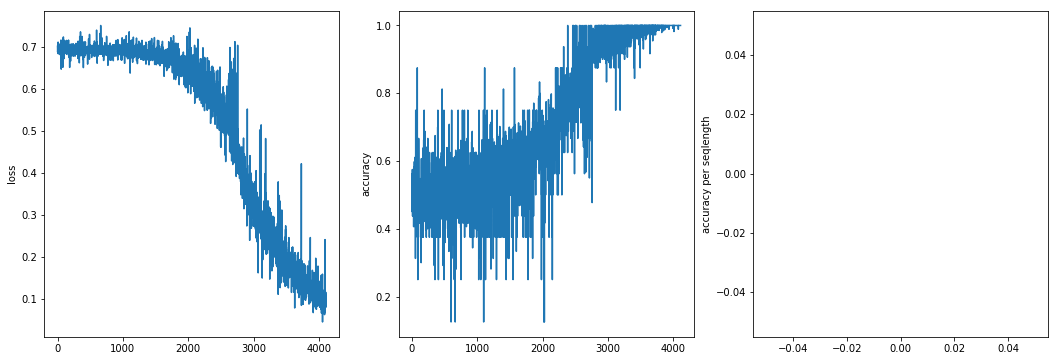

Step: 4112     Loss: 0.1338    Accuracy: 1.0000    Length: 6    


In [ ]:
nb_samples = 0
accuracies = []
losses = []
accuracy_per_seqlength = []
print(0)
for step, inp, out in seqgen:
    nb_samples += batch_size

    ntm.reset()

    loss = 0
    acc = 0
    for i in range(inp.size(0)):
        ntm.send(inp[i])

    for i in range(out.size(0)):
        x = ntm.receive(input_zero)
        loss += criterion(x, out[i])
        acc += (F.sigmoid(x).round() == out[i]).float().mean()[0]

    meanloss = loss.data[0] / out.size(0)
    meanacc = acc.data[0] / out.size(0)
    
    ##accuracy per sequ=length
    
    
    ##

    #if step % 25 == 0:
    accuracies.append(meanacc)
    losses.append(meanloss)
    print(f'Step: {step:<9}'
          f'Loss: {meanloss:<10.4f}'
          f'Accuracy: {meanacc:<10.4f}'
          f'Length: {out.size(0):<5}')
    plt.clf()
    plt.subplot(1,3,1)
    plt.plot(losses)
    plt.ylabel("loss")
    plt.subplot(1,3,2)
    plt.plot(accuracies)
    plt.ylabel("accuracy")
    plt.subplot(1,3,3)
    plt.plot(accuracy_per_seqlength)
    plt.ylabel("accuracy per seqlength")
    plt.gcf().set_size_inches((18,6))

    display.clear_output(wait=True)
    display.display(plt.gcf())

    time.sleep(0.01)
        
    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm(ntm.parameters(), 10)
    opt.step()
